In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from matplotlib.lines import Line2D
import math

# If running on separate laptop/computer, this will need commenting out 
plt.style.use('pythonStyle')
import pythonStyle as ed

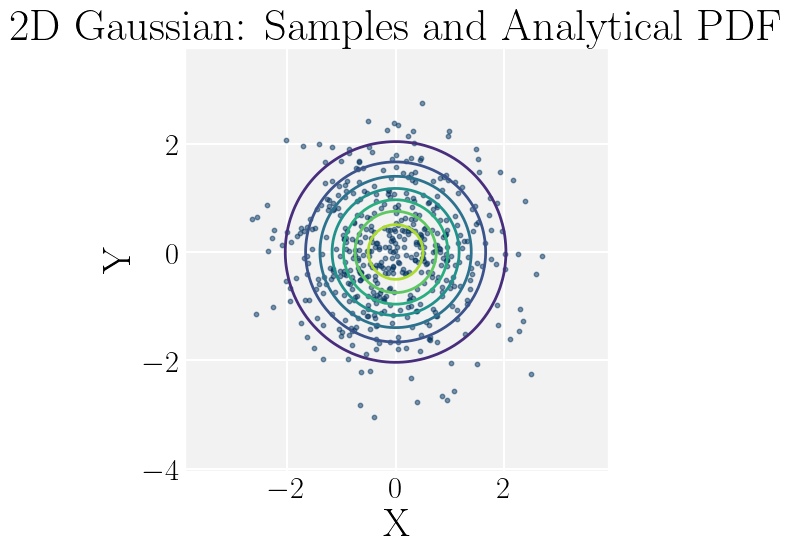

In [2]:
# Parameters for the 2D Gaussian
mu1 = [0, 0]                      # Mean
cov1 = [[1, 0], [0, 1]]           # Covariance matrix

# Generate samples
n_samples = 500
np.random.seed(0)
samples = np.random.multivariate_normal(mu1, cov1, n_samples)

# Define axis limits for square grid
x_min, x_max = np.min(samples[:,0]) - 1, np.max(samples[:,0]) + 1
y_min, y_max = np.min(samples[:,1]) - 1, np.max(samples[:,1]) + 1

# Make ranges equal length for square grid
range_x = x_max - x_min
range_y = y_max - y_min
max_range = max(range_x, range_y)

# Center the ranges to have equal span
x_mid = (x_max + x_min) / 2
y_mid = (y_max + y_min) / 2

x = np.linspace(x_mid - max_range/2, x_mid + max_range/2, 100)
y = np.linspace(y_mid - max_range/2, y_mid + max_range/2, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Compute the analytical PDF on the grid
rv = multivariate_normal(mu1, cov1)
Z = rv.pdf(pos)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(samples[:,0], samples[:,1], s=10, alpha=0.5, label='Samples')
contour = plt.contour(X, Y, Z, linewidths=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Gaussian: Samples and Analytical PDF')

# Set aspect ratio to equal to ensure square axes
plt.axis('square')
plt.grid(True)
plt.show()

Initial h_p: [0.1465176 0.1464579]
[[0.07215435 0.        ]
 [0.         0.07209555]]
x marginal: mean = 7.624908175785094e-05, variance = 0.9964348673820496, std = 1.0
y marginal: mean = 0.00659369258210063, variance = 0.995611846446991, std = 1.0
Integral of pdf_x: 0.9999844947562149
Integral of kde_vals_x: 0.99997133
Integral of pdf_y: 0.9999610784253156
Integral of kde_vals_y: 0.9999508
KL divergence (X marginal): 0.001220
KL divergence (Y marginal): 0.001212


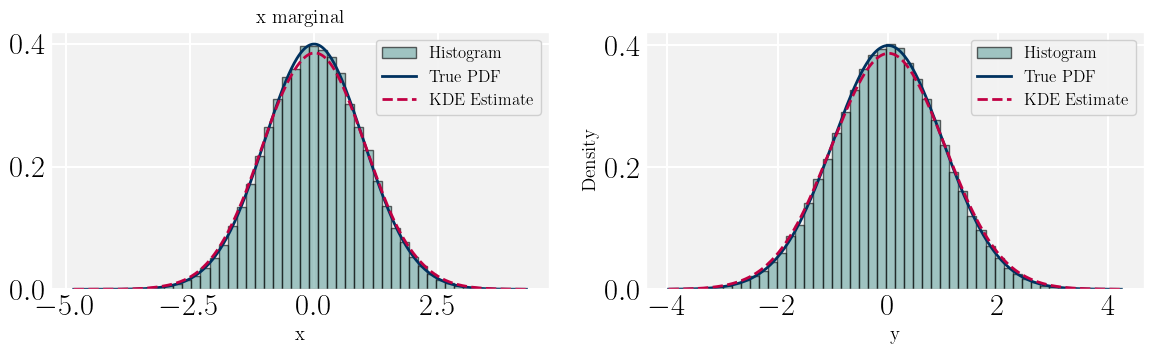

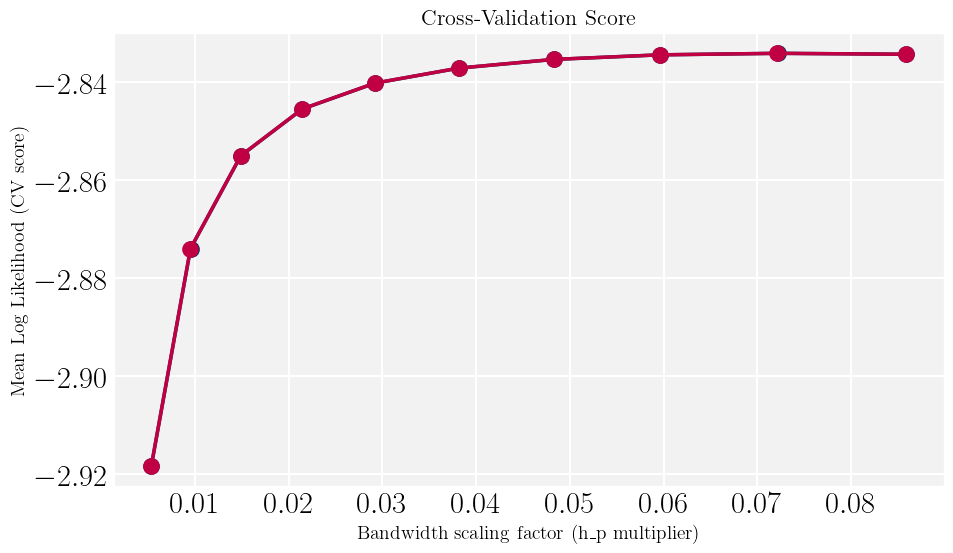

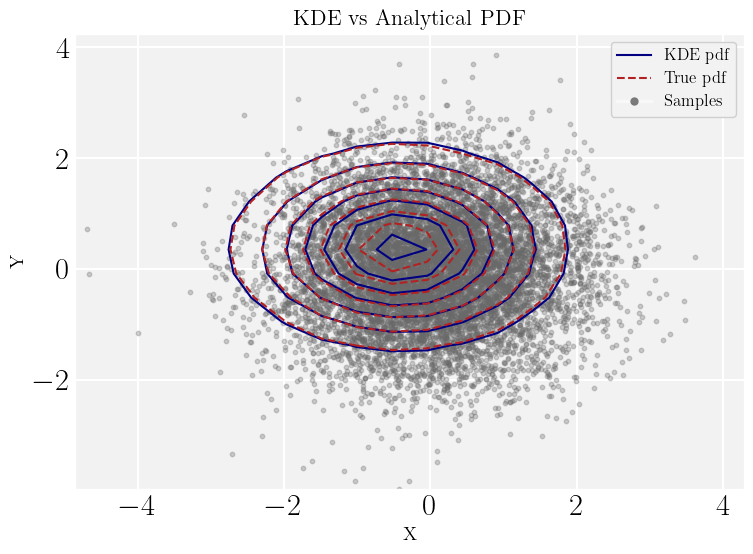

MAE between KDE and Analytical PDF: 0.000583


In [ ]:
# --- Generate 2D Gaussian samples
def generate_2d_gaussian_samples(n, mu, cov, seed=0):
    np.random.seed(seed)
    data = np.random.multivariate_normal(mu, cov, size=n).astype(np.float32)
    return data 

########################################################################

# --- Cross-validation of KDE bandwidth matrix- using subsampling for speed
def calc_kdeCrossValidation_nD(data, H_Matrix_candidateLst, k=5, subsample_size=10000):
    n, d = data.shape
    kf = KFold(n_splits=k, shuffle=True, random_state=42)  # shuffle the data before splitting into k groups
    mean_logLikelihoodLst = []

    # Use subsampling to reduce computation
    if n > subsample_size:
        indices = np.random.choice(n, subsample_size, replace=False)
        data_sub = data[indices]
    else:
        data_sub = data

    for H in H_Matrix_candidateLst:
        H = np.array(H)
        H_inv = np.linalg.inv(H)
        det_H = np.linalg.det(H)

        norm_const = 1.0 / ((2 * np.pi) ** (d / 2) * np.sqrt(det_H))

        fold_log_likelihoods = []

        for train_idx, val_idx in kf.split(data_sub):
            X_train = data_sub[train_idx]
            X_val = data_sub[val_idx]

            diffs = X_val[:, np.newaxis, :] - X_train[np.newaxis, :, :]
            dists = np.einsum('mnd,dd,mnd->mn', diffs, H_inv, diffs)
            K = norm_const * np.exp(-0.5 * dists)

            f_vals = np.mean(K, axis=1)
            f_vals = np.clip(f_vals, 1e-300, None)
            fold_log_likelihoods.append(np.mean(np.log(f_vals)))

        mean_logLikelihoodLst.append(np.mean(fold_log_likelihoods))

    mean_logLikelihoodLst = np.array(mean_logLikelihoodLst)
    optimal_idx = np.argmax(mean_logLikelihoodLst)
    optimalBandwidthMatrix = H_Matrix_candidateLst[optimal_idx]

    return optimalBandwidthMatrix, mean_logLikelihoodLst

# --- Estimate KDE at given points using batching 
def calc_kdeGaussianEstimate_nD(points, data, bandwidth, batch_size=50):
    n, d = data.shape
    m = points.shape[0]

    bandwidth_inv = np.linalg.inv(bandwidth)
    det_bandwidth = np.linalg.det(bandwidth)
    norm_const = 1.0 / ((2 * np.pi) ** (d / 2) * np.sqrt(det_bandwidth))

    densities = np.empty(m, dtype=np.float32)

    for start in range(0, m, batch_size): # calculate in batches to reduce computational load
        end = min(start + batch_size, m)
        batch = points[start:end].astype(np.float32) # slices to get a subset of points (exclusive slicing)
        diffs = batch[:, np.newaxis, :] - data  # (b, n, d)
        D2 = np.einsum('bnd,dd,bnd->bn', diffs, bandwidth_inv, diffs) # einsum - sinstein summation, general syntax is np.einsum(subscripts, *operands), these are the input subscripts bnd,dd,bnd and the output subscript is bn and summuation is over d because it doesnt appear in the outputs
        kernel_vals = norm_const * np.exp(-0.5 * D2)
        densities[start:end] = np.mean(kernel_vals, axis=1)

    return densities

# --- Plotting function - 2d
def plot_kde_vs_pdf_2d(data, kde_vals, pdf_vals, grid_points, mean_scores, hLst):
    x_unique = np.unique(grid_points[:, 0])
    y_unique = np.unique(grid_points[:, 1])
    X, Y = np.meshgrid(x_unique, y_unique)

    x_hLst = [h[0] for h in hLst]
    y_hLst = [h[1] for h in hLst]

    # Plot cross-validation scores
    plt.figure(figsize=(10, 6))
    plt.plot(x_hLst, mean_scores, '-o', label='Distribution One')
    plt.plot(y_hLst, mean_scores, '-o', label='Distribution Two')
    plt.xlabel('Bandwidth scaling factor (h_p multiplier)', fontsize=14)
    plt.ylabel('Mean Log Likelihood (CV score)', fontsize=14)
    plt.title('Cross-Validation Score', fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Downsample data for scatter plot if large
    plot_data = data if data.shape[0] <= 10000 else data[::10]

    plt.scatter(plot_data[:, 0], plot_data[:, 1], c='dimgrey', s=10, alpha=0.3, label='Samples')
    plt.contour(X, Y, kde_vals, colors='navy', linewidths=1.5)
    plt.contour(X, Y, pdf_vals, colors='firebrick', linestyles='dashed', linewidths=1.5)

    legend_elements = [
        Line2D([0], [0], color='navy', lw=1.5, label='KDE pdf'),
        Line2D([0], [0], color='firebrick', lw=1.5, linestyle='dashed', label='True pdf'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=6, label='Samples', alpha=0.5)
    ]

    plt.legend(handles=legend_elements, fontsize=12)
    plt.title(f'KDE vs Analytical PDF', fontsize=16)
    plt.xlabel('X', fontsize=14)
    plt.ylabel('Y', fontsize=14)
    plt.grid(True)
    plt.tight_layout()

    # Set limits for the small variance and mean
    # plt.xlim(0.42, 0.49)
    # plt.ylim(2.5, 2.85)
    
    plt.show()

    mae = np.mean(np.abs(kde_vals - pdf_vals))
    print(f"MAE between KDE and Analytical PDF: {mae:.6f}")

########################################################################

# --- Calculate KL divergence in 1D
def oneDimensionalKLDivergence(data, kde_vals_x, kde_vals_y, pdf_x, pdf_y):




    # Assume uniform spacing
    x_vals = np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), len(kde_vals_x))
    y_vals = np.linspace(np.min(data[:, 1]), np.max(data[:, 1]), len(kde_vals_y))
    dx = x_vals[1] - x_vals[0]
    dy = y_vals[1] - y_vals[0]

    dx = x_vals[1] - x_vals[0]
    dy = y_vals[1] - y_vals[0]

    print("Integral of pdf_x:", np.sum(pdf_x) * dx)
    print("Integral of kde_vals_x:", np.sum(kde_vals_x) * dx)
    print("Integral of pdf_y:", np.sum(pdf_y) * dy)
    print("Integral of kde_vals_y:", np.sum(kde_vals_y) * dy)


    # KL divergence: True vs KDE (D_KL(P || Q))
    kl_x = np.sum(pdf_x * np.log(pdf_x / kde_vals_x)) * dx
    kl_y = np.sum(pdf_y * np.log(pdf_y / kde_vals_y)) * dy

    print(f"KL divergence (X marginal): {kl_x:.6f}")
    print(f"KL divergence (Y marginal): {kl_y:.6f}")


# --- 1D Cross validation
def calc_kdeCrossValidation_1d(data, h_candidateLst, k=5, subsample_size=10000):
    """
    1D KDE cross-validation to select optimal bandwidth.
    Input: 
        - data: (n,) array
        - h_candidateLst: list of scalar bandwidths
    """
    if data.ndim != 1:
        raise ValueError("Input data must be 1D.")

    n = data.shape[0]

    # Shuffle and split data
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    mean_logLikelihoodLst = []

    # Subsampling
    if n > subsample_size:
        indices = np.random.choice(n, subsample_size, replace=False)
        data_sub = data[indices]
    else:
        data_sub = data

    for h in h_candidateLst:
        fold_log_likelihoods = []

        for train_idx, val_idx in kf.split(data_sub):
            X_train = data_sub[train_idx]  # Training data
            X_val = data_sub[val_idx]      # Validation data

            # Calculate kernel matrix
            diff = (X_val[:, None] - X_train[None, :]) / h  # Shape (n_val, n_train)
            K = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * diff**2) / h

            # Estimate density
            f_vals = np.mean(K, axis=1)

            # Numerical stability
            f_vals = np.clip(f_vals, 1e-300, None)

            # Log-likelihood for this fold
            fold_log_likelihoods.append(np.mean(np.log(f_vals)))

        # Average log-likelihood over folds for this h
        mean_logLikelihoodLst.append(np.mean(fold_log_likelihoods))

    mean_logLikelihoodLst = np.array(mean_logLikelihoodLst)
    optimal_idx = np.argmax(mean_logLikelihoodLst)
    optimal_h = h_candidateLst[optimal_idx]

    return optimal_h, mean_logLikelihoodLst

# --- Plot the one dimensional gaussians that make up the 2d distribution
def plot_histograms_with_pdf(data, bandwidthMatrix, bins=50, xName='x', yName='y'):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    mean_x = np.mean(data[:, 0])
    mean_y = np.mean(data[:, 1])
    std_x = np.std(data[:, 0], ddof=0)
    std_y = np.std(data[:, 1], ddof=0)

    print(f"{xName} marginal: mean = {mean_x}, variance = {std_x**2}, std = {round(std_x, 2)}")
    print(f"{yName} marginal: mean = {mean_y}, variance = {std_y**2}, std = {round(std_y, 2)}")

    # KDE
    x_vals = np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), 500)
    pdf_x = norm.pdf(x_vals, loc=mean_x, scale=std_x)
    x_points = x_vals[None, :]  # shape (1, m)
    kde_vals_x = calc_kdeGaussianEstimate_nD(x_points.T, data[:, 0:1], np.array([[bandwidthMatrix[0, 0]]]), batch_size=50)

    y_vals = np.linspace(np.min(data[:, 1]), np.max(data[:, 1]), 500)
    pdf_y = norm.pdf(y_vals, loc=mean_y, scale=std_y)
    y_points = y_vals[:, None]
    kde_vals_y = calc_kdeGaussianEstimate_nD(y_points, data[:, 1:2], np.array([[bandwidthMatrix[1, 1]]]), batch_size=50)

    # KL Divergence
    oneDimensionalKLDivergence(data, kde_vals_x, kde_vals_y, pdf_x, pdf_y)

    axs[0].hist(data[:, 0], bins=bins, density=True, color="#68A5A1", edgecolor='black', alpha=0.6, label="Histogram")
    axs[0].plot(x_vals, pdf_x, lw=2, label="True PDF")
    axs[0].plot(x_vals, kde_vals_x, '--', lw=2, label="KDE Estimate")
    # axs[0].set_title(f"{xName} marginal", fontsize=14)
    # axs[0].set_xlabel(xName, fontsize=14)
    axs[0].set_ylabel("Density", fontsize=14)
    axs[0].legend(fontsize=12)

    axs[1].hist(data[:, 1], bins=bins, density=True, color="#68A5A1", edgecolor='black', alpha=0.6, label="Histogram")
    axs[1].plot(y_vals, pdf_y, lw=2, label="True PDF")
    axs[1].plot(y_vals, kde_vals_y, '--', lw=2, label="KDE Estimate")
    # axs[1].set_title(f"{yName} marginal", fontsize=14)
    # axs[1].set_xlabel(yName, fontsize=14)
    axs[1].set_ylabel("Density", fontsize=14)
    axs[1].legend(fontsize=12)

    plt.tight_layout()
    plt.show()


########################################################################

def generate_nd_grid(data, num_points_per_dim=20):
    """
    Generates an n-dimensional grid covering the range of the data.

    Parameters:
        data: (n_samples, d) array
        num_points_per_dim: number of grid points per dimension

    Returns:
        grid_points: (total_points, d) array of grid points
        mesh: list of n-dimensional meshgrid arrays (X, Y, Z, etc.)
    """
    d = data.shape[1]
    grid_axes = []

    for dim in range(d):
        min_val = np.min(data[:, dim])
        max_val = np.max(data[:, dim])
        axis = np.linspace(min_val, max_val, num_points_per_dim)
        grid_axes.append(axis)

    mesh = np.meshgrid(*grid_axes, indexing='ij')
    grid_points = np.vstack([m.ravel() for m in mesh]).T
    mesh_shape = mesh[0].shape

    return grid_points, mesh, mesh_shape

# --- Main analysis pipeline
def run_2d_gaussian_kde_analysis(mu=[0, 0], cov=[[1, 0], [0, 1]], n=100000, plotting=False):
    
    # Generate data
    data = generate_2d_gaussian_samples(n=n, mu=mu, cov=cov)

    # Plot histograms and true marginals
    n_dims = data.shape[1]
    if plotting == True:
        for i in range(0, n_dims-1):
                data_2d = data[:, [i, i+1]]
                print(f"\n--- Processing dimension ---")
                plot_histograms_with_pdf(data_2d, bins=50, xName='x', yName='y')

    # Calculate Silverman bandwidth vector
    n, d = data.shape
    sigma = np.std(data, axis=0, ddof=1)
    h_p = (4 / (d + 2)) ** (1 / (d + 4)) * n ** (-1 / (d + 4)) * sigma
    print(f'Initial h_p: {h_p}')

    # Create candidate bandwidth matrices
    scaling_factors = np.linspace(0.5, 2.0, 10)

    H_Matrix_candidateLst = []
    hLst = []
    for s in scaling_factors:
        H_diag = (s * h_p) ** 2 
        H_matrix = np.diag(H_diag)
        H_Matrix_candidateLst.append(H_matrix)
        hLst.append(H_diag)

    # Cross-validation
    optimalBandwidthMatrix, mean_logLikelihoodLst = calc_kdeCrossValidation_nD(data, H_Matrix_candidateLst, k=5, subsample_size=10000)
    print(optimalBandwidthMatrix)
    plot_histograms_with_pdf(data, optimalBandwidthMatrix, bins=50)

    grid_points, mesh, mesh_shape = generate_nd_grid(data)

    # KDE Evaluation
    kde_vals = calc_kdeGaussianEstimate_nD(grid_points, data, optimalBandwidthMatrix).reshape(mesh_shape)

    # Calculate true PDF
    mvn = multivariate_normal(mean=mu, cov=cov)
    pdf_vals = mvn.pdf(grid_points).reshape(mesh_shape)

    # Plot results
    if d == 2:
        plot_kde_vs_pdf_2d(data, kde_vals, pdf_vals, grid_points, mean_logLikelihoodLst, hLst=hLst)

    return data, optimalBandwidthMatrix, pdf_vals, kde_vals


# --- Define Distributions and run everything
cov = [
    [1,0],
    [0,1],
]

mu = [0,0]

data, bandwidthMatrix, true_pdf, kde_pdf = run_2d_gaussian_kde_analysis(mu, cov, n=100000)

In [4]:
## NNDE

# --- Generate 2D Gaussian samples
def generate_2d_gaussian_samples(n=1000, mu=[0, 0], cov=[[1, 0], [0, 1]], noise_std=0.1, seed=0):
    np.random.seed(seed)
    data = np.random.multivariate_normal(mu, cov, size=n)
    noise = np.random.normal(loc=0.0, scale=noise_std, size=data.shape)
    noisy_data = data + noise
    return noisy_data

# --- Normalise data, return scaled data and scaler object
def normalise_data(data):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, scaler

########################################################################

# --- NNDE density estimator calculator (expects normalised inputs)
def calc_nndeDensity(x, data, k):
    """
    x and data are assumed normalised already.
    """
    n = data.shape[0] # data set size
    d = data.shape[1] # data dimensionality

    dists = np.linalg.norm(data - x, axis=1) # calculate the euclidean distance

    # Sort distances in ascending order and get the k-th smallest (k-NN distance)
    eps = np.sort(dists)[k-1] # -1 for 0 indexing
    
    # Volume of d-dimensional ball of radius eps (when we say volume, here (in 2d) it is actually area)
    volume = (math.pi ** (d / 2)) * (eps ** d) / math.gamma(d / 2 + 1)

    # NNDE formula: f(x) = k / (n * V)
    prob_density = k / (n * volume)

    return prob_density

# --- NNDE estimate for a set of points (normalized inputs)
def calc_NNDE_2d_estimate(points, data, k):
    """ loop through and calculate the density for each point with a given k"""
    
    densities = np.zeros(points.shape[0])
    for i, x in enumerate(points):
        densities[i] = calc_nndeDensity(x, data, k)
    return densities

# --- Cross-validation function to find optimal k with normalization
def cross_validate_k(data, k_candidateLst, folds=5):
    """
    Perform cross-validation to select the best number of neighbors k.
    Uses mean log likelihood as the score.

    Arguments:
    data -- dataset (n, d)
    k_candiateLst -- list/array of candidate k values
    folds -- number of CV folds

    Returns:
    best_k -- value of k with best mean log likelihood
    mean_scores -- mean log likelihood for each k
    """

    kf = KFold(n_splits=folds, shuffle=True, random_state=0)
    scores = np.zeros((folds, len(k_candidateLst)))

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(data)):
        train_data = data[train_idx]
        test_data = data[test_idx]

        for k_idx, k in enumerate(k_candidateLst):
            log_likelihoods = []
            for x in test_data:
                # Use NNDE, but k must be less than len(train_data)
                k_eff = min(k, len(train_data)-1)
                density = calc_nndeDensity(x, train_data, k_eff)
                log_likelihoods.append(np.log(density))
            scores[fold_idx, k_idx] = np.mean(log_likelihoods) # using mean loglikehood to calculate the score - same as KDE

    mean_scores = np.mean(scores, axis=0)
    best_k_idx = np.argmax(mean_scores)
    best_k = k_candidateLst[best_k_idx]

    return best_k, mean_scores

########################################################################

def oneDimensionalKLDivergence(data, kde_vals_x, kde_vals_y, pdf_x, pdf_y):

    # Assume uniform spacing
    x_vals = np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), len(kde_vals_x))
    y_vals = np.linspace(np.min(data[:, 1]), np.max(data[:, 1]), len(kde_vals_y))
    dx = x_vals[1] - x_vals[0]
    dy = y_vals[1] - y_vals[0]

    # KL divergence: KDE vs True
    kl_x = np.sum(kde_vals_x * np.log(kde_vals_x / pdf_x)) * dx
    kl_y = np.sum(kde_vals_y * np.log(kde_vals_y / pdf_y)) * dy

    # print stuff
    print(f"KL divergence (X marginal): {kl_x:.6f}")
    print(f"KL divergence (Y marginal): {kl_y:.6f}")

########################################################################

# --- Plot the one dimensional gaussians that make up the 2d distribution
def plot_histograms_with_pdf(data, mu, cov, bins=50, bandwidth=0.3):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Extract means and variances and calculate the standard deviation
    mean_x, mean_y = mu[0], mu[1]
    var_x, var_y = cov[0][0], cov[1][1]
    std_x, std_y = np.sqrt(var_x), np.sqrt(var_y)

    print(f"X marginal: mean = {mean_x}, variance = {var_x}, std = {round(std_x, 2)}")
    print(f"Y marginal: mean = {mean_y}, variance = {var_y}, std = {round(std_y, 2)}")

    # X marginal
    x_vals = np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), 500)
    pdf_x = norm.pdf(x_vals, loc=mean_x, scale=std_x)

    kde_x = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde_x.fit(data[:, 0][:, None])
    log_kde_x = kde_x.score_samples(x_vals[:, None])
    kde_vals_x = np.exp(log_kde_x)

    # Y marginal
    y_vals = np.linspace(np.min(data[:, 1]), np.max(data[:, 1]), 500)
    pdf_y = norm.pdf(y_vals, loc=mean_y, scale=std_y)

    kde_y = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde_y.fit(data[:, 1][:, None])
    log_kde_y = kde_y.score_samples(y_vals[:, None])
    kde_vals_y = np.exp(log_kde_y)

    # calculate the KL divergence for each marginal - comment out to speed up quite a bit
    oneDimensionalKLDivergence(data, kde_vals_x, kde_vals_y, pdf_x, pdf_y)

    axs[0].hist(data[:, 0], bins=bins, density=True, color='skyblue', edgecolor='black', alpha=0.6, label="Histogram")
    axs[0].plot(x_vals, pdf_x, lw=2, label="True PDF")
    axs[0].plot(x_vals, kde_vals_x,'--', lw=2, label="KDE Estimate")
    axs[0].set_title("X marginal", fontsize=14)
    axs[0].set_xlabel("x", fontsize=14)
    axs[0].set_ylabel("Density", fontsize=14)
    axs[0].legend(fontsize=12)

    axs[1].hist(data[:, 1], bins=bins, density=True, color='salmon', edgecolor='black', alpha=0.6, label="Histogram")
    axs[1].plot(y_vals, pdf_y, lw=2, label="True PDF")
    axs[1].plot(y_vals, kde_vals_y,'--', lw=2, label="KDE Estimate")
    axs[1].set_title("Y marginal", fontsize=14)
    axs[1].set_xlabel("y", fontsize=14)
    axs[1].set_ylabel("Density", fontsize=14)
    axs[1].legend(fontsize=12)

    plt.tight_layout()
    plt.show()

def plot_nnde_vs_pdf_2d(data, k_opt, mean_scores, ks, mu, cov):
    # Normalize entire data for NNDE grid evaluation
    data_scaled, scaler = normalise_data(data)

    # Define grid for PDF evaluation based on original data range with margin
    x = np.linspace(np.min(data[:,0]) - 1, np.max(data[:,0]) + 1, 100)
    y = np.linspace(np.min(data[:,1]) - 1, np.max(data[:,1]) + 1, 100)
    X, Y = np.meshgrid(x, y)
    grid_points = np.vstack([X.ravel(), Y.ravel()]).T

    # Normalize grid points using the scaler fitted on data
    grid_points_scaled = scaler.transform(grid_points)

    # Calculate NNDE estimate of PDF on normalized grid
    NNDE_vals = calc_NNDE_2d_estimate(grid_points_scaled, data_scaled, k_opt).reshape(X.shape)

    # Calculate analytical PDF on original grid points
    mvn = multivariate_normal(mean=mu, cov=cov)
    pdf_vals = mvn.pdf(grid_points).reshape(X.shape)

    # Plot CV scores for different k values
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(ks, mean_scores, '-o')
    plt.xlabel('Number of Neighbors (k)', fontsize=14)
    plt.ylabel('Mean Log Likelihood (CV score)', fontsize=14)
    plt.title('Cross-Validation Score', fontsize=16)
    plt.grid(True)

    # Plot NNDE and analytical PDF comparison
    plt.subplot(1, 2, 2)
    # Set square axes and equal scaling
    side_min = min(np.min(x), np.min(y))
    side_max = max(np.max(x), np.max(y))
    plt.xlim(side_min, side_max)
    plt.ylim(side_min, side_max)
    plt.axis('square')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xticks(np.arange(np.ceil(side_min), np.floor(side_max) + 1, 1))
    plt.yticks(np.arange(np.ceil(side_min), np.floor(side_max) + 1, 1))

    # Scatter samples
    plt.scatter(data[:, 0], data[:, 1], c='dimgrey', s=10, alpha=0.3, label='Samples')

    # Contour plots (no label argument for contour)
    cont1 = plt.contour(X, Y, NNDE_vals, colors='navy', linewidths=1.5)
    cont2 = plt.contour(X, Y, pdf_vals, colors='firebrick', linestyles='dashed', linewidths=1.5)

    # Create manual legend handles
    legend_elements = [
        Line2D([0], [0], color='navy', lw=1.5, label='NNDE PDF'),
        Line2D([0], [0], color='firebrick', lw=1.5, linestyle='dashed', label='Analytical PDF'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='dimgrey', markersize=6, label='Samples', alpha=0.3)
    ]
    plt.legend(handles=legend_elements, fontsize=12)
    plt.title(f'NNDE vs Analytical PDF (k_opt={k_opt})', fontsize=16)
    plt.xlabel('X', fontsize=14)
    plt.ylabel('Y', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    mae = np.mean(np.abs(NNDE_vals - pdf_vals))
    print(f"MAE between NNDE and Analytical PDF: {mae:.6f}")

########################################################################

# --- Wrapper to run full 2D Gaussian NNDE analysis
def run_2d_gaussian_NNDE_analysis(mu, cov, n=1000):
    np.random.seed(0)
    data = generate_2d_gaussian_samples(n=n, mu=mu, cov=cov, seed=0)
    plot_histograms_with_pdf(data, mu, cov)
    k_candidateLst = np.arange(500, 1500, 25)
    k_opt, mean_scores = cross_validate_k(data, k_candidateLst, folds=3)
    plot_nnde_vs_pdf_2d(data, k_opt, mean_scores, k_candidateLst, mu, cov)

varX = 1
varY = 1
covariance = 0

muX = 0
muY = 0

cov=[[varX, covariance], [covariance, varY]]
mu=[muX, muY]

n = 15000
# run_2d_gaussian_NNDE_analysis(mu, cov, n) 